<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

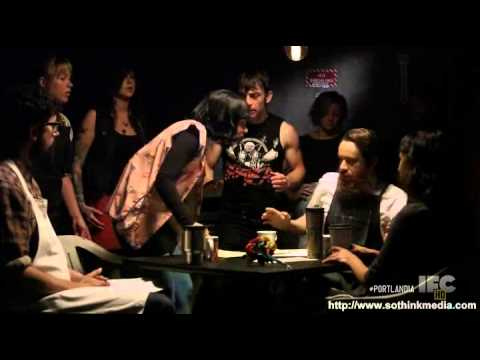

In [5]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [2]:
%pwd

'/Users/jonathansokoll/Documents/lambda/DS-Unit-4-Sprint-1-NLP/module1-text-data'

In [3]:
from bs4 import BeautifulSoup
import plotly
import re 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np
import spacy


In [4]:
import pandas as pd

url = "https://raw.githubusercontent.com/geraldm24/DS-Unit-4-Sprint-1-NLP/main/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


In [5]:
# convert string to integer
shops['star_rating2'] = shops['star_rating'].str.extract(r'(\d+)', expand=False).astype(int)


In [8]:
nlp = spacy.load('en_core_web_lg')

In [25]:
# lemmatization
from spacy.tokenizer import Tokenizer
from nltk.stem import PorterStemmer

def get_lemmas(text):
    lemmas = []
    doc = nlp(text)
    for token in doc:
        if(((token.is_stop == False) and (token.is_punct == False))
        and (token.pos_ != "PRON")) :
            lemmas.append(token.lemma_.lower())
    return lemmas
shops['reviews'] = shops['full_review_text'].apply(get_lemmas)   

## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

In [6]:
# counter function
from collections import Counter
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

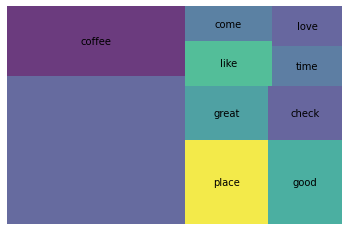

In [32]:
import squarify
wc = count(shops['reviews'])
top10 = wc[wc['rank']<= 10]
squarify.plot(sizes=top10['pct_total'],label=top10['word'],alpha=.8)
plt.axis('off')
plt.show()

In [34]:
top10.word.values

array([' ', 'coffee', 'place', 'good', 'great', 'check', 'like', 'come',
       'time', 'love'], dtype=object)

In [27]:
stopWords = nlp.Defaults.stop_words.union(' ', 'coffee', 'place', 'good', 'great', 'check', 'like', 'come',
       'time', 'love','eat','food','taste')

In [57]:
def get_lemmas(text):
    lemmas = []
    doc = nlp(text)
    for token in doc:
        if(((token.text not in stopWords) and (token.is_punct == False))
        and (token.pos_ != "PRON")) :
            lemmas.append(token.lemma_)
    lemmas = list(set(lemmas))        # remove stop words
    return lemmas


In [58]:
shops['tokenz'] = shops['full_review_text'].apply(get_lemmas)

In [49]:
w = pd.DataFrame(stopWords)
w = w.rename(columns={0:'words'})
w['lemmas'] = w['words'].apply(get_lemmas)
w.lemmas

AttributeError: 'set' object has no attribute 'upper'

In [48]:
w.lemmas.unique

<bound method Series.unique of 0      []
1      []
2      []
3      []
4      []
       ..
337    []
338    []
339    []
340    []
341    []
Name: lemmas, Length: 342, dtype: object>

In [55]:
print(shops['tokens'].str.contains('coffee')).

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
7611   NaN
7612   NaN
7613   NaN
7614   NaN
7615   NaN
Name: tokens, Length: 7616, dtype: float64


## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


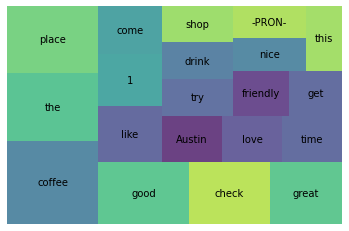

In [59]:
import squarify
wc = count(shops['tokenz'])
top20 = wc[wc['rank']<= 20]
squarify.plot(sizes=top20['pct_total'],label=top20['word'],alpha=.8)
plt.axis('off')
plt.show()

In [65]:
good = shops[shops['star_rating2'] >= 4]
bad = shops[shops['star_rating2'] <= 3]

In [71]:
def squareplot(wc):
   
    wc = count(wc)
    shop10 = wc[wc['rank']<= 10]
    squarify.plot(sizes=shop10['pct_total'],label=shop10['word'],alpha=.8)
    plt.axis('off')
    return plt.show()



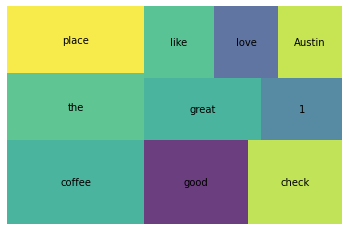

In [72]:
s = squareplot(good['tokenz'])

## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

